#### File Setup

In [134]:
#pip install pycountry-convert --quiet
#pip install seaborn  --quiet
#pip install scipy --quiet
#pip install researchpy --quiet
#pip install statsmodels --quiet

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [490]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
import statsmodels.api as sm

In [520]:
csv_file = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 1/data/Dissertation - Risky Choice Framing_July 18, 2023_08.57.csv"
df = pd.read_csv(csv_file)
print(df.shape)

(141, 97)


In [493]:
#df.columns

In [515]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 97 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   StartDate                      141 non-null    object 
 1   EndDate                        141 non-null    object 
 2   Status                         141 non-null    object 
 3   Progress                       141 non-null    int64  
 4   Duration (in seconds)          141 non-null    int64  
 5   Finished                       141 non-null    bool   
 6   RecordedDate                   141 non-null    object 
 7   ResponseId                     141 non-null    object 
 8   DistributionChannel            141 non-null    object 
 9   UserLanguage                   141 non-null    object 
 10  Q_RecaptchaScore               133 non-null    float64
 11  Q1. Metadata_Browser           141 non-null    object 
 12  Q1. Metadata_Version           141 non-null    obj

#### Basic Data Cleaning 

In [521]:
##### Data cleaning to change column types

#drop anyone now sorted into condition 
df_clean = df.drop(df[df['Condition'].isna()].index)

#change data type to int 
df_clean['Condition'] =  df_clean['Condition'].astype('int64')

# create frame column gain or loss condition based on condition value 
df_clean['frame'] = df_clean['Condition'].apply(lambda x: 'gain' if x < 3 else 'loss')

#filter only where progress = 100 
df_clean = df_clean[df_clean['Progress']==100]
print(df_clean.shape)

(126, 98)


In [522]:
## survey timing & outlier removal 

## visual completion times 
#sns.histplot( y='Duration (in seconds)', data =df_clean)
#plt.show()

#look at completion times 
df_clean['Duration (in seconds)'].describe()

def remove_outliers(df, column_name):
    # Calculate Z-scores for the column
    z_scores = stats.zscore(df[column_name])
    threshold = 3 #3 standard deviations 
    # Filter the dataframe to keep only the data within the threshold
    df_clean = df[abs(z_scores) < threshold]

    return df_clean

#apply function to remove outliers 
column_name = 'Duration (in seconds)'
df_clean = remove_outliers(df_clean, column_name) 

df_clean.shape

(123, 98)

In [ ]:
### check for NAs 

##### Mapping Columns & Cleaning

In [523]:
#### Creating columns and grouping for various scenarios:
# dictionary mapping
scenario_dict = {"GS1":"animals_gain", "GS2":"forest_gain", "GS3":"humans_gain", "LS1":"animals_loss", "LS2":"forest_loss", "LS3":"humans_loss"  }

#set columns based on scenario 
def scenario(row):
    for col in selected_columns:
        if pd.notnull(row[col]):
            match = re.search(r'(GS\d+|LS\d+)', col)
            if match:
                return match.group()
    return None
# get scenario from dictionary 
def get_scenario(row):
    value = row['scenario']
    if value in scenario_dict:
        return scenario_dict[value]
    return None
# match scenario to dict
df_clean['scenario'] = df_clean[['Q12. GS1, Option','Q12. GS2, Option', 'Q12. GS3, Option.', 'Q12. LS1, Option', 'Q12. LS2, Option', 'Q12. LS3, Option']].apply(lambda row: scenario(row), axis=1)
df_clean['scenario_mapped'] = df_clean.apply(lambda row: get_scenario(row), axis=1)

In [524]:
import re
##### Option Column Cleaning
# select option columns 
df_clean['option_selected'] = df_clean[['Q12. GS1, Option','Q12. GS2, Option', 'Q12. GS3, Option.', 'Q12. LS1, Option', 'Q12. LS2, Option', 'Q12. LS3, Option']].fillna(method='ffill', axis=1).iloc[:, -1]
option_columns = ['Q12. GS1, Option','Q12. GS2, Option', 'Q12. GS3, Option.', 'Q12. LS1, Option', 'Q12. LS2, Option', 'Q12. LS3, Option']

#rating column clean & creation 
rating_columns = ['Q13. GS1, Rating','Q13. GS2, Rating', 'Q13. GS3, Rating', 'Q13. LS1, Rating', 'Q13. LS2, Rating', 'Q13. LS3, Rating']
df_clean['rating'] = df_clean[rating_columns].fillna(method='ffill', axis=1).iloc[:, -1]
df_clean['rating_num'] = df_clean['rating'].apply(lambda x: x.split(":")[0])
df_clean['rating_num'] = df_clean['rating_num'].astype('int')

#rationale column cleaning
rationale_columns = ['Q13. GS1, Rationale','Q14. GS2, Rationale', 'Q14. GS3, Rationle', 'Q14. LS1, Rationale', 'Q14. LS2, Rationale', 'Q14. LS3, Rationale']
df_clean['rationale'] = df_clean[rationale_columns].fillna(method='ffill', axis=1).iloc[:, -1]

##### drop standalone choice, rationale, and rating columns
colu = rationale_columns + option_columns + rating_columns
df_clean = df_clean.drop(colu, axis= 'columns')

In [526]:
### Cleaning and dropping time columns ###
columns = list(df_clean.columns)

###  First click columns
time_click1 = [col for col in columns if 'first click' in col.lower()]
#time first click for the scenario 
time_click1_scn = [string for string in time_click1 if string.startswith('Q10')]
#make as 1 column 
df_clean['scn_t_first_click'] = df_clean[time_click1_scn].fillna(method='ffill', axis=1).iloc[:, -1]

### Last click columns
time_click2 = [col for col in columns if 'last click' in col.lower()]
time_click2_scn = [string for string in time_click2 if string.startswith('Q10')]
df_clean['scn_t_last_click'] = df_clean[time_click2_scn].fillna(method='ffill', axis=1).iloc[:, -1]

### Time Submit Scenario columns
time_submit = [col for col in columns if 'submit' in col.lower()]
time_submit_scn = [string for string in time_submit if string.startswith('Q10')]
df_clean['scn_t_submit'] = df_clean[time_submit_scn].fillna(method='ffill', axis=1).iloc[:, -1]

#click_count1_scn = [string for string in click_count1 if 'dem' in string.lower()]

## drop Q10 time columns 
columns_drop = time_click2_scn + time_click1_scn + time_submit_scn
df_clean = df_clean.drop(columns_drop, axis = 'columns')

##Click count cleaning 
columns = list(df_clean.columns)
## Click Count for Scenario 
click_count1 = [col for col in columns if 'click count' in col.lower()]
#filer only scenario click coun t
click_count_scn = [string for string in click_count1 if string.startswith('Q10')]
#make as 1 column for all scenarios 
df_clean['scn_click_count'] = df_clean[click_count_scn].fillna(method='ffill', axis=1).iloc[:, -1]

## Click Count for Scenario 
click_count = [col for col in columns if 'click count' in col.lower()]
click_count1_dem = [string for string in click_count if 'dem' in string.lower()]
df_clean['dem_click_count'] = df_clean[click_count1_dem].fillna(method='ffill', axis=1).iloc[:, -1]

# drop scenario and dem click count columns 
columns_drop = click_count_scn + click_count1_dem
df_clean = df_clean.drop(columns_drop, axis = 'columns')

### drop metadata or misc columns from analysis 
metadata_or_misc = ['Q1. Metadata_Browser','Q1. Metadata_Version', 'Q1. Metadata_Operating System','Q1. Metadata_Resolution', 'UserLanguage', 'DistributionChannel', 'Status']
df_clean = df_clean.drop(metadata_or_misc, axis = 'columns')


In [527]:
df_clean.shape

(123, 58)

### Demographics

##### Cleaning 

In [528]:
#rename columns 
df_clean = df_clean.rename(columns={
    'Q5. Age': 'age',
    'Q6. Gender': 'gender',
    'Q6. Gender_4_TEXT': 'gender_text',
    'Q8. Ethnicity': 'ethnicity',
    'Q8. Ethnicity_6_TEXT': 'ethnicity_text',
    'Q9. Education': 'education',
    'Q10. Country': 'country',
    'Q10. Student': 'student',
    'Q91': 'ADP_familiar'
})

In [530]:
###coutry name clean 
import pycountry_convert as pc

#function to rename messy countries
def rename_countries(country):
    if pd.isnull(country):  # Check if the value is nan
        return country
    if country in ['United States of America', 'USA', 'US', 'us', 'usa', 'America', 'America   ', 'the United States', 'The United States',  'United States ', 'Amrican', 'United States', 'Florida', 'New York', 'MA', 'NZ', 'North Carolina', 'Newyork', 'denver']:
        return 'USA'
    elif country in ['United Kingdom', 'United Kingdom ', 'UK', 'England', 'England ', 'Cambridge', 'London', 'uuk', 'the Netherlands']:
        return 'UK'
    elif country in ['China', '中国', 'Chinese ', '美国','加州']:
        return 'China'
    elif country in [ 'New Zealand']:
        return 'New Zealand'
    elif country in ['Paris, France', 'France']:
        return 'France'
    elif country in ['Australia', 'Australia ']:
        return 'Australia'
    elif country in ['pakistan']:
        return 'Pakistan'
    else:
        return country  # return the original name if no match is found

#update country column 
df_clean['country'] = df_clean['country'].apply(rename_countries)
#strip any remaining whitespaces
df_clean['country'] = df_clean['country'].apply(lambda x: x.strip() if isinstance(x, str) else x) #checks if string, then removes spaces 

# Map each country to the continent
def country_to_continent(country_name):
    try:
        if country_name == 'USA':
            country_alpha2 = "US"
        elif country_name == 'UK':
            country_alpha2 = "GB"
        else:
            country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return "Unknown"

df_clean['continent'] = df_clean['country'].apply(country_to_continent)

In [531]:
###### Cat Code Variables #########

# ####Gender: clean gender column into numbers
#0 if female, 1 if male, 2 if non-binary 
df_clean['gender_num'] = df_clean.gender.apply(lambda x: 0 if x == 'Female' else (1 if x == 'Male' else 2))
df_clean.groupby(['gender','gender_num'])['ResponseId'].count()

####Student: clean student column into numbers
#0 if not a student, 1 if a student
df_clean['student_num']= df_clean.student.astype('category').cat.codes
df_clean.groupby(['student','student_num'])['ResponseId'].count()

####Education: clean education column into numbers
#education_num: 0 = Associates, 1 = Bachecholars, 2 = Completed High School, 3 = Grad School, 4 = Prefer Not to Say, 5 = Some high school 
df_clean['education_num']= df_clean.education.astype('category').cat.codes
df_clean.groupby(['education','education_num'])['ResponseId'].count()

#### Ethnicity: clean ethnicity column into numbers
#ethnicity: 0 = African American, 1 = Black/African/Caribbean, 2 = Prefer not to say, 3 = White or Caucasian
df_clean['ethnicity_num']= df_clean.ethnicity.astype('category').cat.codes
df_clean.groupby(['ethnicity','ethnicity_num'])['ResponseId'].count()

#### Continent: clean contintent column into numbers
#continent: 0 = Asia, 1 = Europe, 2 = North America, 3 = Oceania, 4 = South America, 5 = Unknown 
df_clean['contintent_num']= df_clean.continent.astype('category').cat.codes
df_clean.groupby(['continent','contintent_num'])['ResponseId'].count()

#### ADP: lean ADP column into numbers
#ADP: 0 = I'm not sure, 1 = No, 2 = Yes 
df_clean['ADP_num']= df_clean.ADP_familiar.astype('category').cat.codes
df_clean.groupby(['ADP_familiar','ADP_num'])['ResponseId'].count()

#### Age: clean age column into numbers
#age: {'18 - 24 years old': 0, '25 - 34 years old': 1, '35 - 44 years old': 2, '45 - 54 years old': 3, '55 - 64 years old': 4}
age_order = ['18 - 24 years old', '25 - 34 years old', '35 - 44 years old', '45 - 54 years old', '55 - 64 years old']
age_mapping = {age: i for i, age in enumerate(age_order)}
df_clean['age_num'] = df_clean['age'].map(age_mapping) #maps dict 


In [537]:
## Check for NA values 
#print(df_clean[['age_num','age']].isna().value_counts())
#print(df_clean['education'].isna().value_counts())
#print('\n\n',df_clean['ADP_num'].isna().value_counts())
#df_clean['ADP_familiar'].isna().count()

# NA printing 
#print(f"""school NA: {df_clean['student'].isna().sum()}""")
#print(f"""gender NA: {df_clean['gender'].isna().sum()}""")
#print(f"""education NA: {df_clean['education'].isna().sum()}""")
#print(f"""ADP NA: {df_clean['ADP_familiar'].isna().sum()}""")
dem = ['student','education','gender','ADP_familiar']

print(df_clean[dem].isna().sum())

student         2
education       2
gender          2
ADP_familiar    5
dtype: int64


#### Demographic Insights 

Defintions
- gender_num: 0 = female, 1 = male, 2 = other
- student_num: 0 = not a studnet, 1 = a student, -1 = NA
- education_num: 0 = Associates, 1 = Bachecholars, 2 = Completed High School, 3 = Grad School, 4 = Prefer Not to Say, 5 = Some high school 
- ethnicity: 0 = African American, 1 = Black/African/Caribbean, 2 = Prefer not to say, 3 = White or Caucasian
- continent: 0 = Asia, 1 = Europe, 2 = North America, 3 = Oceania, 4 = South America, 5 = Unknown 
- ADP: 0 = I'm not sure, 1 = No, 2 = Yes 
- age: {'18 - 24 years old': 0, '25 - 34 years old': 1, '35 - 44 years old': 2, '45 - 54 years old': 3, '55 - 64 years old': 4}

##### Participant Demographic Insights 

In [507]:
#Participant Demographic Insights 
demographics =   [ 'ResponseId','gender_num', 'gender', 'student_num', 'student','education_num', 'education','ethnicity_num','ethnicity', 'contintent_num', 'continent','age_num', 'age', 'ADP_num', 'ADP_familiar'] 
df_demographics = df_clean[demographics]

#ethnicity
print(df_demographics.ethnicity.value_counts(normalize=True))

ethnicity
White or Caucasian         0.710744
Asian                      0.157025
Black/African/Caribbean    0.123967
Prefer not to say          0.008264
Name: proportion, dtype: float64


In [508]:
##Demographic Insights 
#df_clean.education.value_counts(normalize = True)
#df_clean.groupby(['education_num','frame']).ResponseId.agg(['count', 'sum', 'mean','median'])
#ed = df_clean.groupby(['education_num','frame']).ResponseId.count().reset_index()
#pivoted = ed.pivot(index='education_num', columns='frame', values='ResponseId')
#df_clean[['education_num','frame']].value_counts(normalize =True)

#df_clean.groupby('continent').ResponseId.count()

In [538]:
gen_cross_tab = pd.crosstab(df_clean['gender'], df_clean['frame'])
cross_tab

frame,gain,loss
gender,,
Female,28,25
Male,28,38
Non-binary / third gender,2,1
Prefer not to say,1,0
Prefer to self-describe,1,0


In [510]:
df_clean.groupby(['age', 'age_num'])['ResponseId'].count()

age                age_num
18 - 24 years old  0          20
25 - 34 years old  1          75
35 - 44 years old  2          23
45 - 54 years old  3           3
55 - 64 years old  4           2
Name: ResponseId, dtype: int64

In [539]:
#summary insights 
df_clean.groupby(['frame','scenario','scenario_mapped','option_selected']).ResponseId.count()

#% in each condition (gain or loss)
df_clean['frame'].value_counts()


frame
loss    64
gain    59
Name: count, dtype: int64

In [ ]:
#ADP question 
df_clean['Q91'].value_counts()

### NEP Scoring

In [772]:
columns = df_clean.columns
#nep columns only
nep_columns = [col for col in columns if col.startswith('Q. NEP')]

#function to clean likert score data 
def extract_score(likert): 
   match = re.search(r'\d', likert)
   if match: 
      return int(match.group(0))
   return 0
   
# apply function to nep columns 
for col in df_clean[nep_columns]: 
   df_clean[col] = df_clean[col].astype(str)
df_clean[nep_columns] = df_clean[nep_columns].applymap(extract_score)

# function to sum score
def sum_score(row):
   if pd.notna(row).all():  #all nep questions answered
      return row.sum()
   else:
      return "N/A"

#new column that sums score
df_clean['NEP_Score'] = df_clean[nep_columns].apply(lambda row: sum_score(row), axis=1)

In [780]:
#some insights on each NEP question
stats_by_q = df_clean[nep_columns].describe().T
stats_by_q

,count,mean,std,min,25%,50%,75%,max
Q. NEP_1,123.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Q. NEP_2,123.0,1.967480,0.982928,0.0,1.0,2.0,3.0,4.0
Q. NEP_3,123.0,1.934959,1.061547,0.0,1.0,2.0,3.0,5.0
Q. NEP_4,123.0,1.951220,1.062426,0.0,1.0,2.0,3.0,5.0
Q. NEP_5,123.0,1.934959,1.069241,0.0,1.0,2.0,3.0,5.0
Q. NEP_6,123.0,1.967480,1.055314,0.0,1.0,2.0,3.0,5.0
Q. NEP_7,123.0,2.089431,1.055882,0.0,1.0,2.0,3.0,5.0
Q. NEP_8,123.0,1.943089,1.073533,0.0,1.0,2.0,3.0,5.0


### Main Data Analysis 

In [781]:
main_analysis_columns = ['ResponseId', 'frame', 'scenario_mapped', 'option_selected', 'rating_num', 'age_num',  'gender_num',  'ethnicity_num', 'education_num',   'contintent_num', 'ADP_num', 'student_num']
analysis_columns = ['ResponseId', 'frame', 'scenario_mapped', 'option_selected', 'rating', 'rating_num', 'rationale',
'age', 'age_num', 'gender',  'gender_num', 'ethnicity', 'ethnicity_num', 'education', 'education_num', 'continent',  'contintent_num', 
'ADP_num','ADP_familiar',  'student', 'student_num', 'NEP_score']



#set up dataframe 
main_analysis = df_clean[main_analysis_columns]

#gain & loss conditions 
gain_condition = main_analysis[main_analysis['frame']=='gain']
loss_condition = main_analysis[main_analysis['frame']=='loss']

#% of Participants Selecting Each Option 
frame_cross_tab1 = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'], normalize='columns')
frame_cross_tab2 = pd.crosstab(main_analysis['option_selected'], main_analysis['frame'])
frame_cross_tab1 




frame,gain,loss
option_selected,,
Proposal A,0.779661,0.640625
Proposal B,0.220339,0.359375


In [782]:
lossB = loss_condition[loss_condition['option_selected']=='Proposal B']
lossA = loss_condition[loss_condition['option_selected']=='Proposal A']

main_analysis.isna().sum()

ResponseId         0
frame              0
scenario_mapped    0
option_selected    0
rating_num         0
age_num            0
gender_num         0
ethnicity_num      0
education_num      0
contintent_num     0
ADP_num            0
student_num        0
dtype: int64

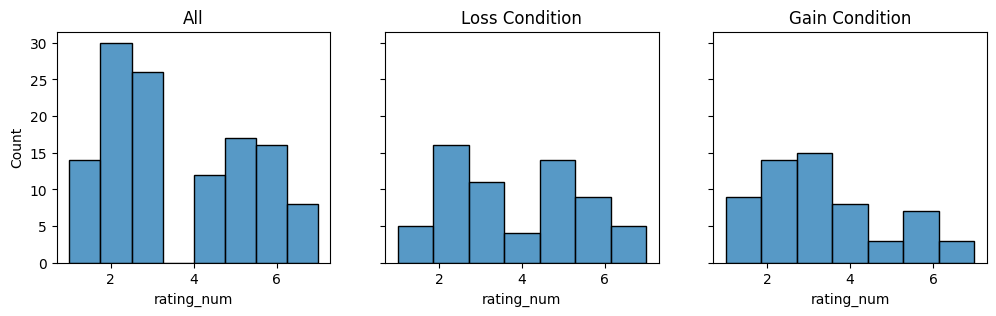

In [792]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

sns.histplot(data=main_analysis, x='rating_num', ax=axes[0])
axes[0].set_title('All')
sns.histplot(data=loss_condition, x='rating_num', ax=axes[1])
axes[1].set_title('Loss Condition')
sns.histplot(data=gain_condition, x='rating_num', ax=axes[2])
axes[2].set_title('Gain Condition')

plt.show()


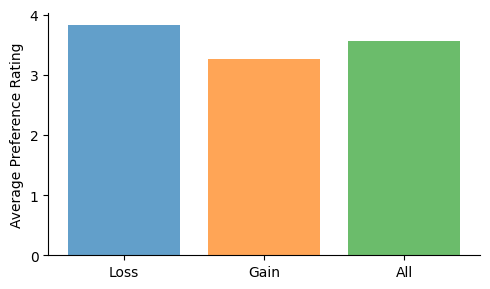

In [802]:
##Plot graph for average rating by condition 
values = np.array([loss_condition.rating_num.mean(), gain_condition.rating_num.mean(), main_analysis.rating_num.mean()])
plt.figure(figsize=(5,3))
plt.bar(np.arange(3), values,  color=[ 'C0', 'C1', 'C2'], alpha=0.7, capsize=1, ecolor='dimgrey')
sns.despine()
plt.ylabel('Average Preference Rating')
plt.xticks(np.arange(3), ['Loss', 'Gain', 'All'], rotation='horizontal')
plt.tight_layout()
#plt.show()

In [390]:
print("\nAverage rating by condition & option:")
print(pd.crosstab( index = main_analysis['option_selected'], columns = main_analysis['frame'], values = main_analysis['rating_num'], aggfunc='mean'))

print("\nAverage rating by condition:")
print(main_analysis.groupby('frame').rating_num.mean())


Average rating by condition & option:
frame                gain      loss
option_selected                    
Proposal A       2.840909  2.775000
Proposal B       4.818182  5.571429

Average rating by condition:
frame
gain    3.236364
loss    3.737705
Name: rating_num, dtype: float64


In [381]:
#ttest for experiment 

gain = main_analysis['rating_num'][main_analysis['frame'] == 'gain']
loss = main_analysis['rating_num'][main_analysis['frame'] == 'loss']

t_stat, p_value = stats.ttest_ind(gain, loss)

# results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -1.5306182058640971
P-value: 0.1286340462083498


In [434]:
#function for signficance 
def sig_effect(pvalue):
    if pvalue <= .01:
        return f"""significant at 1% level"""
    elif pvalue <= .05:
        return f"""significant at 5% level"""
    elif pvalue <= .1:
        return f"""significant at 10% level"""
    else:
        return "not significant"


significant at 1% level


In [443]:
#simple linear regression 
lin_reg = sm.OLS.from_formula('rating_num ~ frame', data = main_analysis).fit()
print(lin_reg.pvalues)
print("\nsignficicant effect?", sig_effect(lin_reg.pvalues[1]))
print("\n\n",lin_reg.params)
print(lin_reg.t_test)
print("\n\n\n",lin_reg.summary())


Intercept        1.122710e-25
frame[T.loss]    1.286340e-01
dtype: float64

signficicant effect? not significant


 Intercept        3.236364
frame[T.loss]    0.501341
dtype: float64
<bound method LikelihoodModelResults.t_test of <statsmodels.regression.linear_model.OLSResults object at 0x12ac21b50>>



                             OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.343
Date:                Wed, 19 Jul 2023   Prob (F-statistic):              0.129
Time:                        23:45:07   Log-Likelihood:                -229.26
No. Observations:                 116   AIC:                             462.5
Df Residuals:                     114   BIC:                             468.0
Df Model:                           1                         

In [444]:
#with basic demographic controls 
reg_dem = sm.OLS.from_formula('rating_num ~ frame + age_num + gender_num + ethnicity_num + education_num', data = main_analysis).fit()
print("frame coeff:", reg_dem.params[1])
print("frame p-vale:", reg_dem.pvalues[1])
print("\nsignficicant effect?", sig_effect(reg_dem.pvalues[1]))
print("\n\n\n",reg_dem.summary())


frame coeff: 0.6227607493994483
frame p-vale: 0.062066944220374724

signficicant effect? significant at 10% level



                             OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.852
Date:                Wed, 19 Jul 2023   Prob (F-statistic):              0.109
Time:                        23:45:27   Log-Likelihood:                -225.76
No. Observations:                 116   AIC:                             463.5
Df Residuals:                     110   BIC:                             480.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------

In [446]:
#with addl. demographic controls 
reg_dema = sm.OLS.from_formula('rating_num ~ frame + age_num + gender_num + ethnicity_num + education_num + contintent_num + student_num', data = main_analysis).fit()
print("frame coeff:", reg_dema.params[1])
print("frame p-vale:", reg_dema.pvalues[1])
print("\nsignficicant effect?", sig_effect(reg_dema.pvalues[1]))
print("\n\n",reg_dema.summary())


frame coeff: 0.6868559284391104
frame p-vale: 0.03740350523744158

signficicant effect? significant at 5% level


                             OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     2.222
Date:                Wed, 19 Jul 2023   Prob (F-statistic):             0.0378
Time:                        23:46:14   Log-Likelihood:                -222.64
No. Observations:                 116   AIC:                             461.3
Df Residuals:                     108   BIC:                             483.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------

In [450]:
#with ADP num 
reg_ADP = sm.OLS.from_formula('rating_num ~ frame + age_num + gender_num + ethnicity_num + education_num + contintent_num + student_num + ADP_num', data = main_analysis).fit()
print("frame coeff:", reg_ADP.params[1])
print("frame p-vale:", reg_ADP.pvalues[1])
print("\nsignficicant effect?", sig_effect(reg_ADP.pvalues[1]))
print("\n\n",reg_ADP.summary())


frame coeff: 0.5013412816691514
frame p-vale: 0.12863404620834992

signficicant effect? not significant


                             OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.343
Date:                Wed, 19 Jul 2023   Prob (F-statistic):              0.129
Time:                        23:52:12   Log-Likelihood:                -229.26
No. Observations:                 116   AIC:                             462.5
Df Residuals:                     114   BIC:                             468.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------